In [1]:
from __future__ import annotations

# Standard libraries
import logging
import math
import random
from contextlib import contextmanager
from functools import partial
from operator import attrgetter, itemgetter
from pathlib import Path

# Third-party libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch import nn, optim, tensor

# fastai/fastcore libraries
import fastcore.all as fc
from fastcore.test import test_close

# Custom libraries (miniai, datasets)
from datasets import load_dataset
from miniai.datasets import *
from miniai.learner import *

In [2]:
# PyTorch settings and matplotlib settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

In [3]:
# Disable logging warnings
logging.disable(logging.WARNING)

In [4]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

## Baseline

In [6]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [7]:
from torcheval.metrics import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [8]:
def fit(model, epochs=1, xtra_cbs=None):
    learner = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learner.fit(epochs)
    return learner

accuracy,loss,epoch,train
0.154,2.301,0,train
0.191,2.156,0,eval


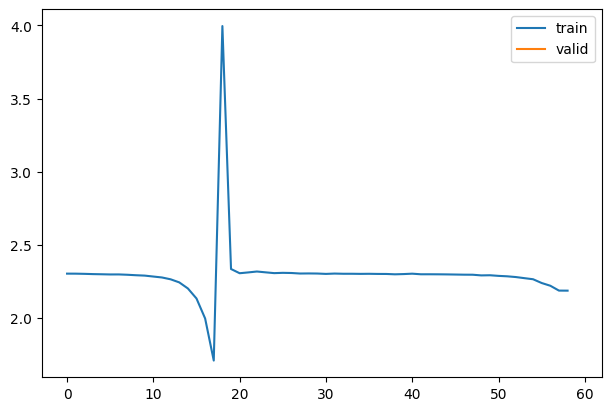

In [9]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

In [10]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [11]:
cnn_layers()

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Flatten(start_dim=1, end_dim=-1)]

accuracy,loss,epoch,train
0.156,2.297,0,train
0.274,2.035,0,eval


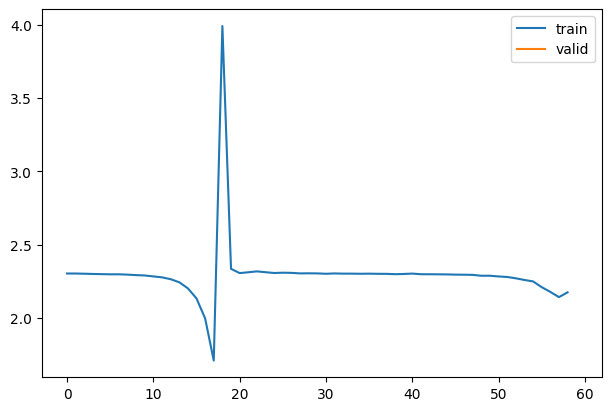

In [12]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

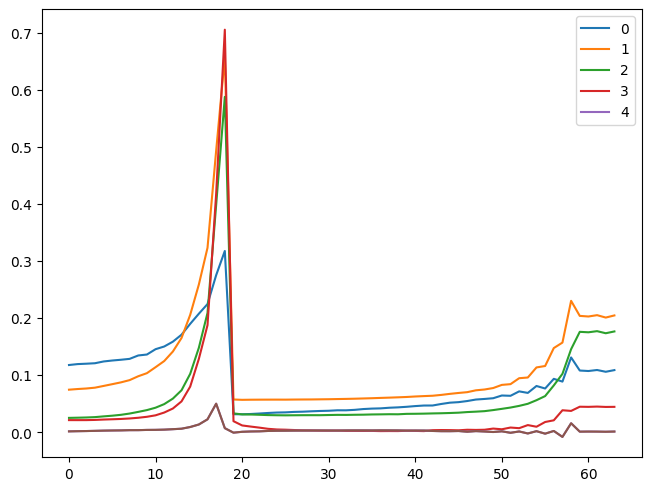

In [13]:
for l in model.act_means: 
    plt.plot(l)
plt.legend(range(5));

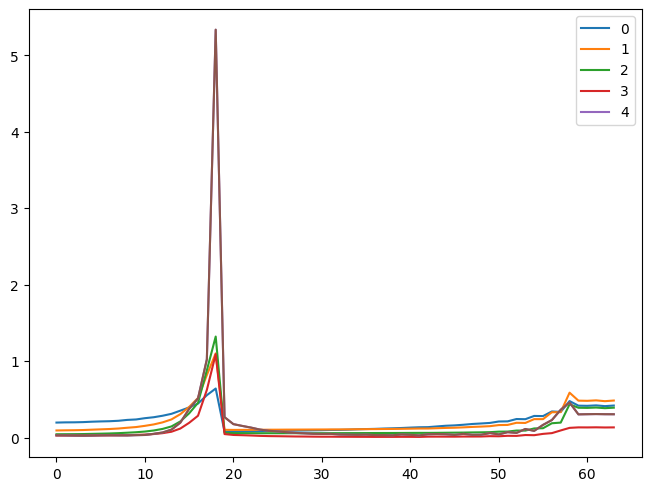

In [14]:
for l in model.act_stds: 
    plt.plot(l)
plt.legend(range(5));

## PyTorch Hooks

Hooks are PyTorch objects you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [15]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [16]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [17]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [18]:
for i,layer in enumerate(model):
    layer.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.156,2.297,0,train
0.290,2.013,0,eval


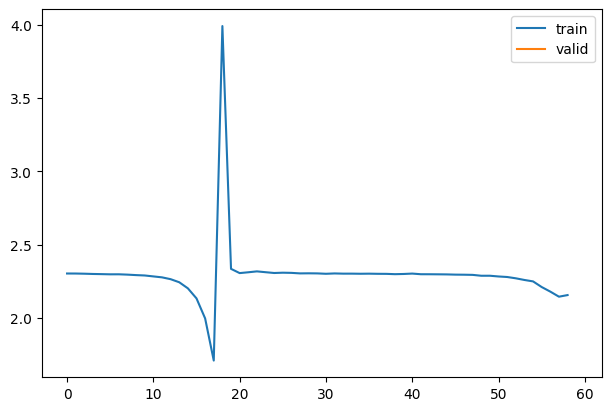

In [19]:
fit(model)

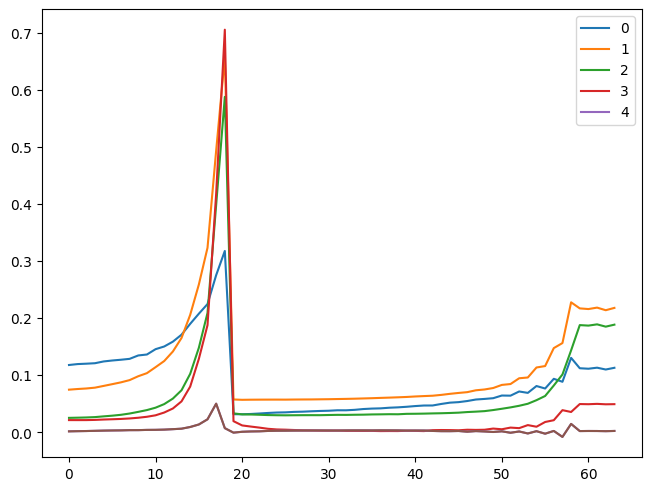

In [20]:
for o in act_means: 
    plt.plot(o)
plt.legend(range(5));

## Hook Class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [21]:
class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

In [22]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [23]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [24]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.154,2.302,0,train
0.203,2.126,0,eval


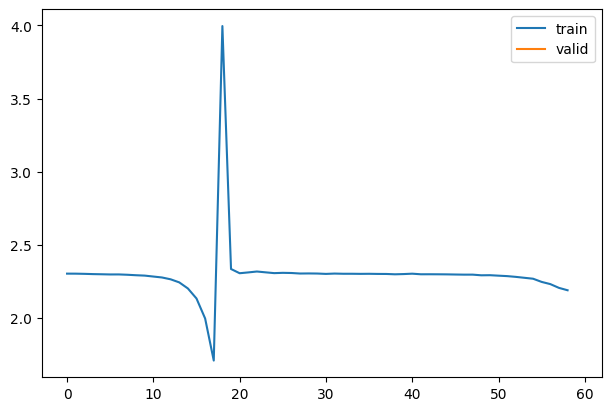

In [25]:
learn = fit(model)

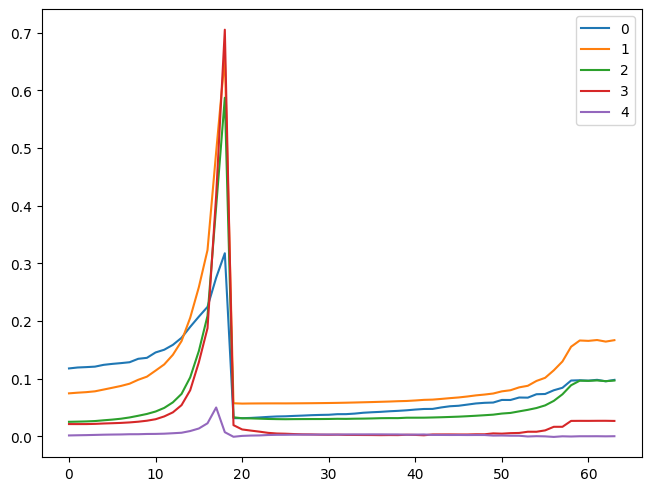

In [26]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

## Hooks Ctx Manager

In [27]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args):
        print("all done!")
    def hello(self):
        print("hello.")

In [28]:
with DummyCtxMgr() as dcm:
    dcm.hello()

let's go!
hello.
all done!


In [29]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [30]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [31]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

In [32]:
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args):
        return self
    def __exit__ (self, *args):
        self.remove()
    def __del__(self):
        self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self:
            h.remove()

In [33]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.154,2.302,0,train
0.203,2.126,0,eval


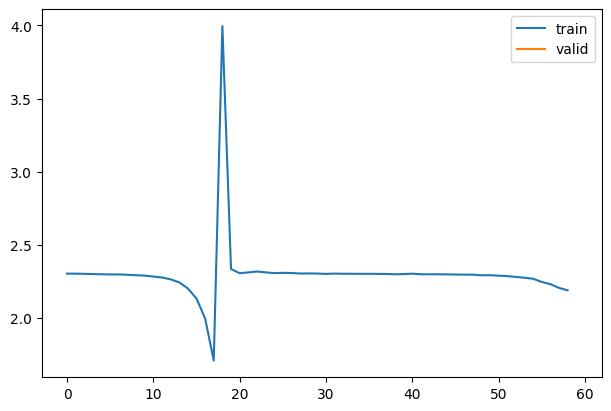

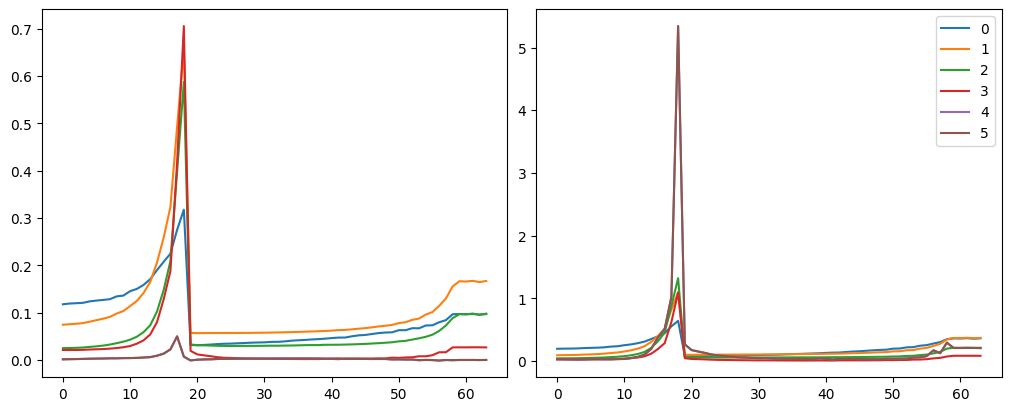

In [34]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: 
            axs[i].plot(h.stats[i])
    plt.legend(range(6));

## HooksCallback

In [35]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods:
            mods = self.mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)

    def after_fit(self, learn):
        self.hooks.remove()
    def __iter__(self):
        return iter(self.hooks)
    def __len__(self):
        return len(self.hooks)

In [36]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.156,2.298,0,train
0.278,2.051,0,eval


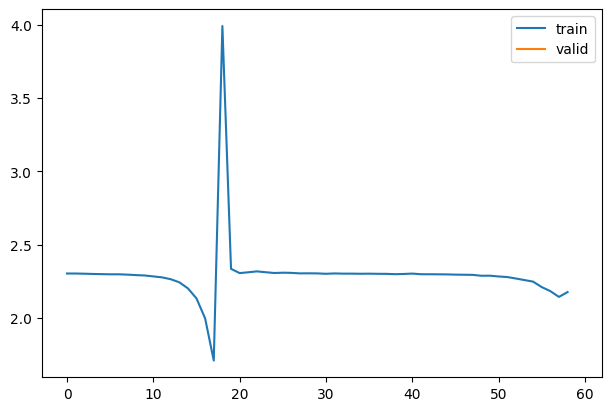

In [37]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

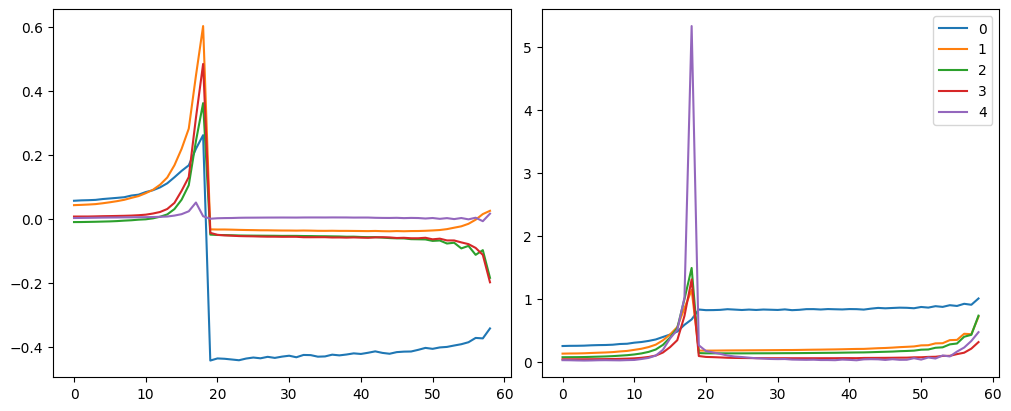

In [38]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1:
        axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

In [39]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.156,2.297,0,train
0.290,1.988,0,eval


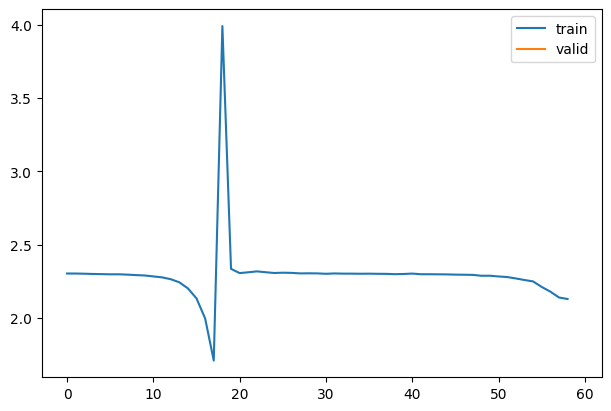

In [40]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [41]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

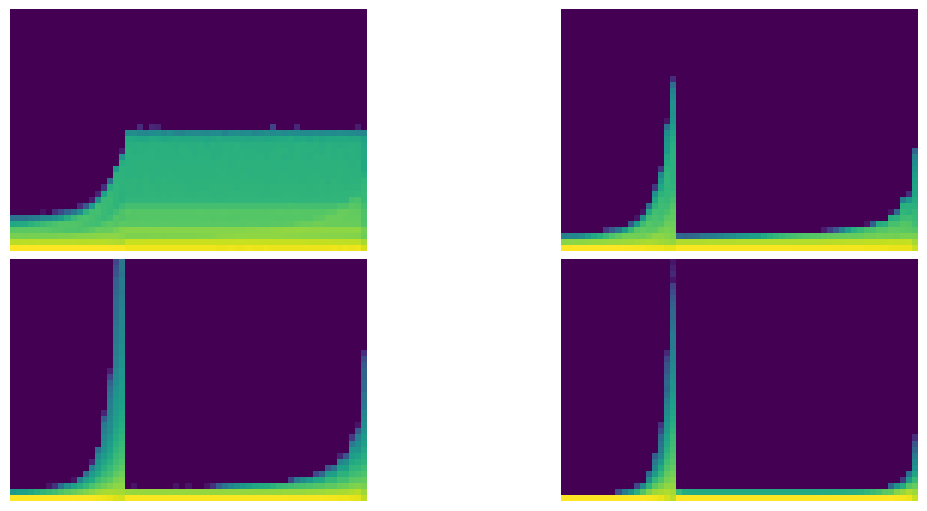

In [42]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [43]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

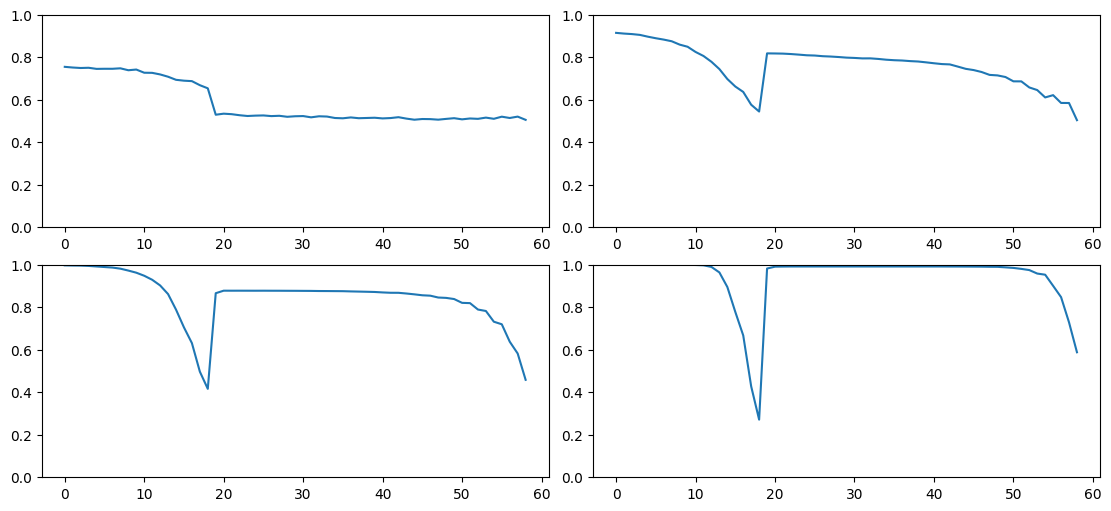

In [44]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

#### Notes

`HooksCallback` lets us "hook" into specific layers of our neural network during training. But what's a hook? Think of it like adding an observer to specific layers (in this case, convolutional layers) to record data—like the neuron activations—at every forward pass. We then use these hooks to gather statistics, like the mean and standard deviation of the activations, and even visualize their distribution over time.

In this specific setup, we're interested in:

1. Mean of the activations: How active are the neurons on average?
2. Standard deviation: How spread out or variable are the neuron outputs?
3. Activation histogram: How often do neurons "fire" across different ranges of values.

These statistics are collected to help us understand if our network is functioning well. For instance, if many neurons are always inactive (e.g., outputting zeros), they are "dead neurons." Dead neurons are a common problem in deep networks, and detecting them early can help us tweak the model.

##### Why Hooks?
The challenge in understanding deep learning models is that you can’t just look at the loss and accuracy—you need to look at what’s happening inside the model. Hooks allow us to do exactly that, in a non-intrusive way. They let us "peek" into the model without affecting its behavior. It’s like getting a running commentary during training to help you make sense of what’s happening under the hood.

##### The `HooksCallback` Class
Now, let's talk about the HooksCallback class. It’s a base class that sets up hooks and manages their lifecycle (i.e., when to start recording, when to stop). The key parts here:

`before_fit`: Before training starts, it sets up the hooks on the layers you're interested in. The mod_filter lets you select which layers you want to observe (in this case, convolutional layers via `nn.Conv2d`).
`_hookfunc`: This is where the real work happens. It defines what should happen when the hook is triggered. In this case, it either records data during training or validation, depending on the flags `on_train` and `on_valid`.
`after_fit`: After training finishes, the hooks are removed to clean up.

##### Recording Activations: `append_stats`
Next comes `append_stats`, which is a function that gets called every time a forward pass happens (thanks to the hook). Its job is to record the statistics—mean, standard deviation, and a histogram of absolute values of the activations. These stats tell you how the neurons are behaving during training. Are they firing frequently, or are some of them "dead"?

##### The Visualization
We don’t just collect stats for fun; we visualize them to get insights. The functions `color_dim` and `dead_chart` in the `ActivationStats` class provide these visual insights:

`color_dim`: This method plots the histograms of activations. The visual result can show whether the neurons are activating in a healthy way—spread across a range of values—or if most are stuck in a narrow range.

`dead_chart`: This method focuses on dead neurons—those that are consistently outputting near-zero values. If many neurons are dead, you might need to adjust the network (e.g., change activation functions, tweak the learning rate, etc.).

## ActivationStats

In [45]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [46]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.153,2.299,0,train
0.232,2.150,0,eval


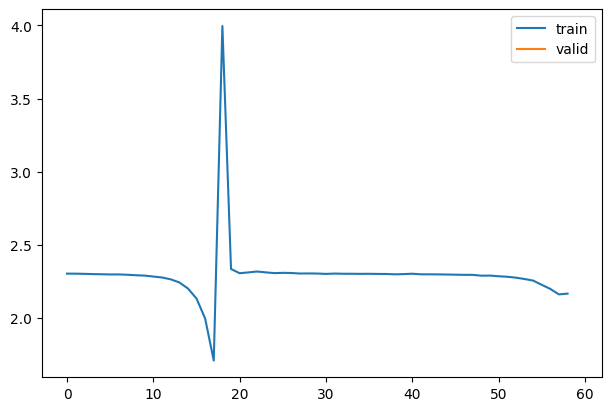

In [47]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

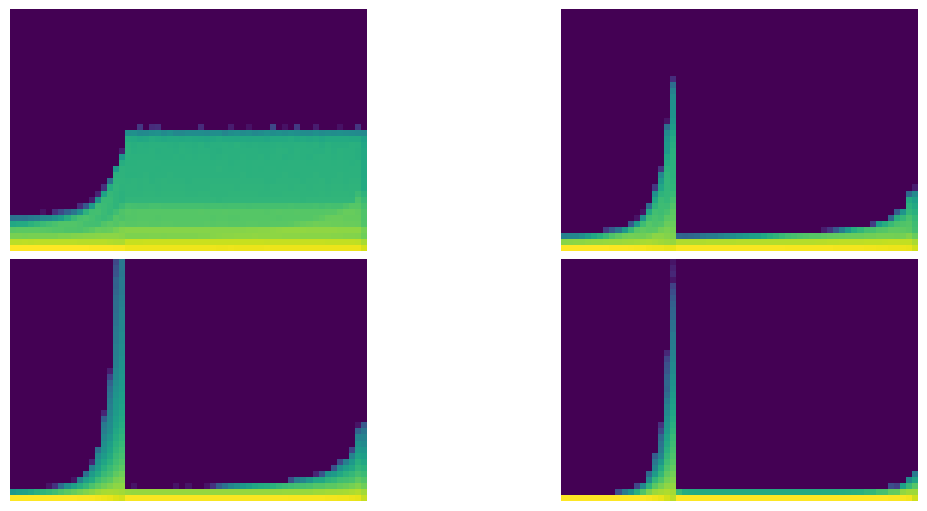

In [48]:
astats.color_dim()

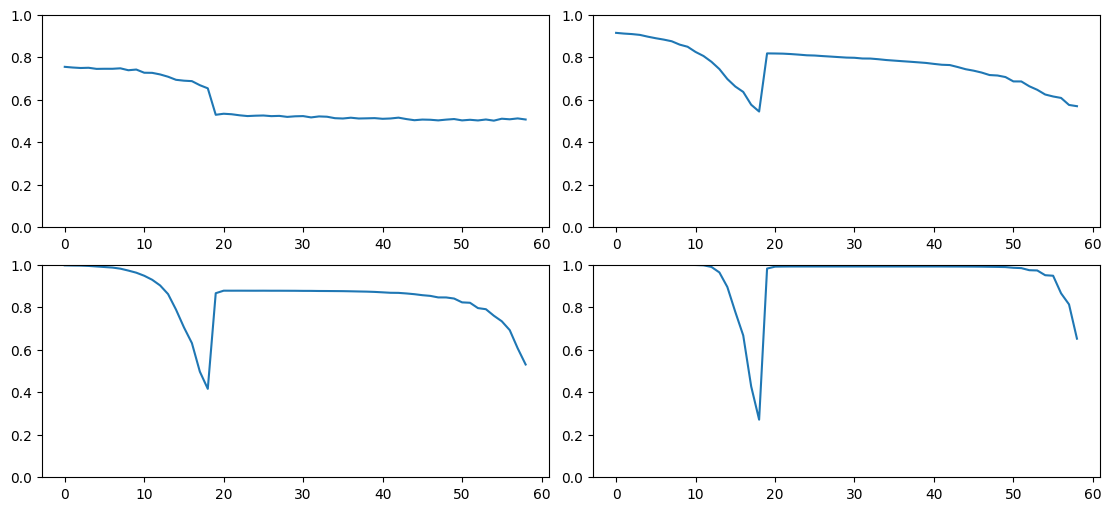

In [49]:
astats.dead_chart()

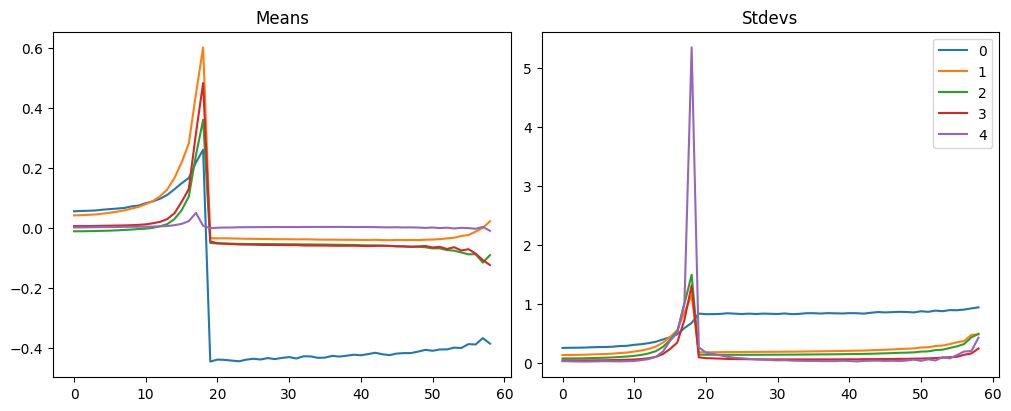

In [50]:
astats.plot_stats()